# Optimization of Planetary Transits

In this notebook I will perform optimization fitting on transits.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
from lightkurve.injection import TransitModel
import lightkurve.injection as inj
import scipy.optimize as op

In [2]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

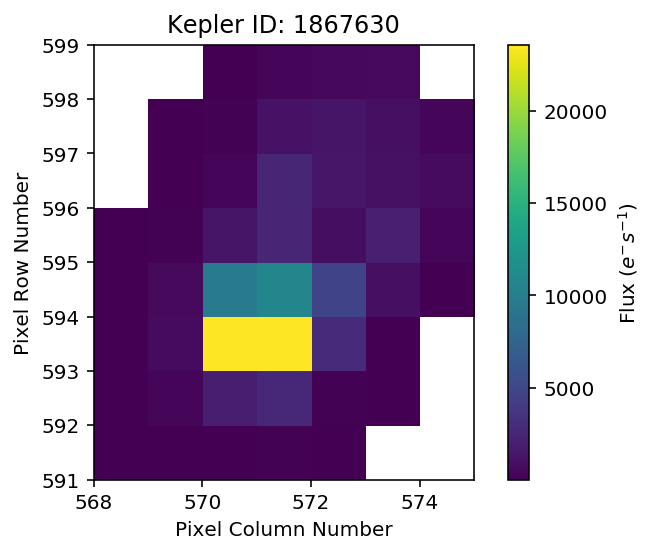

In [3]:
#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

tpf.plot();

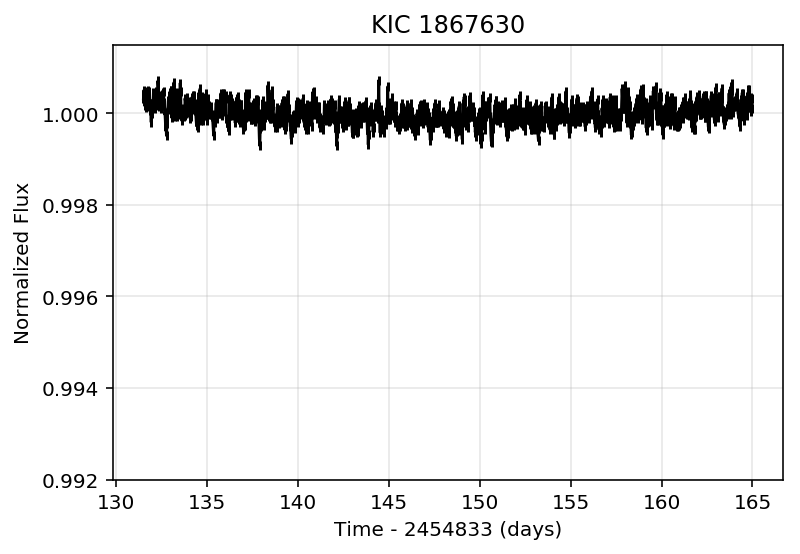

In [4]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(.992, 1.0015);
plt.savefig('/Users/sheilasagear/supernovae/plots/gtype_star')

In [109]:
lcinj = lcinj.normalize()

[1.00032802 1.0005099  1.00035994 ... 1.00005954 1.00011217 1.00032729]


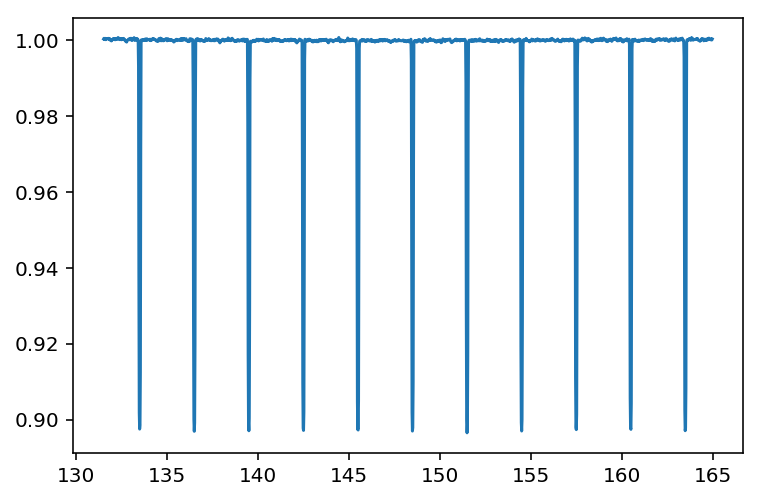

In [171]:
modelinj = inj.TransitModel()
modelinj.add_star()
modelinj.add_planet(3, 0.3, 133.5)
lcinj = inj.inject(lc, modelinj)
model_eval = modelinj.evaluate(lc.time)

lcinj = lcinj.normalize()
plt.plot(lcinj.time, lcinj.flux)
#plt.plot(lcinj.time, model_eval)
print(lcinj.flux)

In [172]:
def ln_like(theta, x, y, yerr):
    period, rprs, T0 = theta
    model = TransitModel()
    model.add_star()
    model.add_planet(period, rprs, T0)
    model_flux = model.evaluate(x)
    inv_sigma2 = 1.0/(yerr**2)
    chisq = (np.sum((y-model_flux)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


def lnprior_optimization(theta, x, y, yerr):
    period, rprs, T0 = theta
    if period < 0 or rprs > 0.5:
        return -1.e99
    return 0.0


def neg_ln_posterior(theta, x, y, yerr):
    log_posterior = lnprior_optimization(theta, x, y, yerr) + ln_like(theta, x, y, yerr)
    return -1 * log_posterior

In [180]:
%%time

#Injected values: T0=2600, z=0.5, amplitude=1e-7
x0 = [4, 0.1, 133]

result = op.minimize(neg_ln_posterior, x0, args=(lcinj.time, lcinj.flux, lcinj.flux_err))

CPU times: user 3.43 s, sys: 194 ms, total: 3.63 s
Wall time: 3.86 s


In [181]:
print(result)
period_f, rprs_f, T0_f = result["x"]

      fun: 24284332.657781996
 hess_inv: array([[ 2.74795297e-10, -2.76669203e-09, -1.04460488e-09],
       [-2.76669203e-09,  1.24175261e-07,  1.79176644e-08],
       [-1.04460488e-09,  1.79176644e-08,  5.41248645e-09]])
      jac: array([94.5, -1. , 23.5])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 426
      nit: 44
     njev: 85
   status: 2
  success: False
        x: array([3.97258769e+00, 5.35834499e-03, 1.33091352e+02])


In [175]:
new_model = inj.TransitModel()
new_model.add_star()
new_model.add_planet(period_f, rprs_f, T0_f)
new_fit = new_model.evaluate(lc.time)

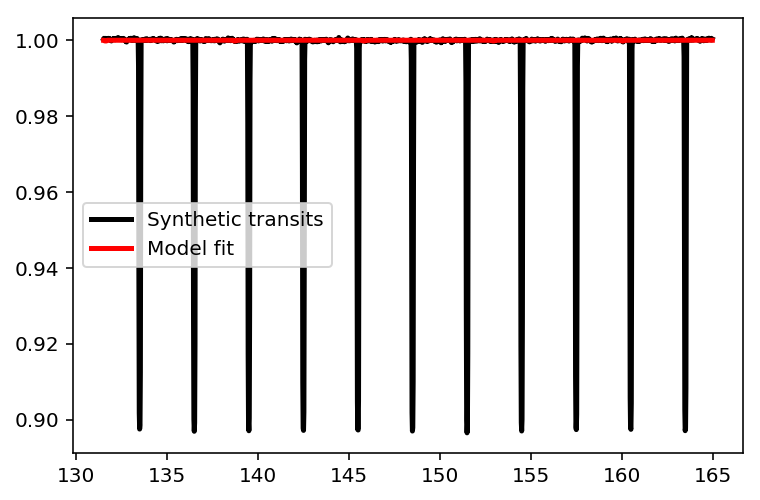

In [176]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic transits', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()

In [ ]:
from lightkurve import injection as inj